In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

import obe_jax as obj

import matplotlib.pyplot as plt
%matplotlib inline

# Fitting a noisy function

Assume we have a system that takes in a single input $x$ and outputs a single output $y$.

The relationship between input and output variables depends on one parameter in addition the input:

$$y = f(\alpha,x)$$


Also, let's assume that there is Gaussian noise with mean $y$ and standard deviation $\sigma$.

Our task is to observe $y$ for different inputs $x$ and infer both $\alpha$ and $\sigma$ from the data.

### First we will define the true parameters that we are attempting to infer


In [2]:
α_true = 3.14159
sigma_true = 0.12
true_params = jnp.asarray([α_true,sigma_true])

### Next we define the likelihood of observing an output $y'$ given an input x and a set of model parameters

In [6]:
@jax.jit
def y_mean(x,α):
    return jnp.sin(x*α) ## Feel free to change this function to whatever you'd like to play around

y_means = jax.jit(jax.vmap(y_mean,in_axes=(0,None)))

@jax.jit
def likelihood_function(oneinput_vector,oneoutput_vector,oneparameter_vector):
    x = oneinput_vector[0]
    m, sigma = oneparameter_vector
    yout = oneoutput_vector[0]
    
    mu = y_mean(x,m)
    p = jnp.exp(-0.5*((mu-yout)/sigma)**2)/(jnp.sqrt(jnp.pi*2)*sigma)
    return p

### Next we define our initial guess regarding possible values of mu and sigma. 

### I.e., our "prior" knowledge of mu and sigma.

In [29]:
key = jax.random.PRNGKey(123)
key, subkey = jax.random.split(key)
N_particles = 1000
mins = jnp.array([0.,0.])
maxs = jnp.array([6.0,0.3])
prior_particles = obj.priors.uniform_prior_particles(subkey,mins,maxs,N_particles)
prior_weights = jnp.full((N_particles,),1/N_particles)

### And define the potential outputs we may observe

In [30]:
N_outcomes = 1000
expected_outcomes = jnp.linspace(-2,2,N_outcomes).reshape((1,N_outcomes))

### Now we define our Bayseian model

In [51]:
key,subkey = jax.random.split(key)
pdf = obj.AbstractBayesianModel(subkey,prior_particles, prior_weights, expected_outcomes,
                                likelihood_function=likelihood_function)

In [52]:
pdf.mean()

Array([3.0400381 , 0.15074503], dtype=float64)

### Next we will generate a synthetic dataset and visualize it

In [53]:
N_data_points = 10
inputs = jnp.linspace(0.,5., N_data_points).reshape((1,N_data_points))
outputs = pdf.sample_outputs(inputs,true_params)

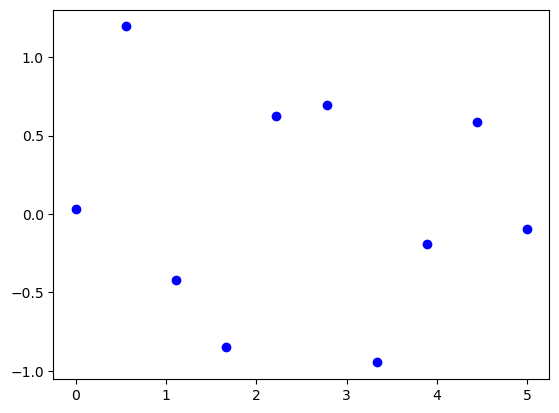

In [54]:
fig, ax = plt.subplots(1,1)
ax.plot(inputs[0,:],outputs[0,:],'bo')
plt.show()

### Now we will infer the systems parameters

In [55]:
pdf.batch_bayesian_update(inputs,outputs)

In [56]:
pdf.mean()

Array([3.15996709, 0.17790816], dtype=float64)

In [57]:
pdf.covariance()

Array([[ 0.00080566, -0.00012806],
       [-0.00012806,  0.00150585]], dtype=float64)

In [58]:
true_params

Array([3.14159, 0.12   ], dtype=float64)

## Visualize the posterior distribution

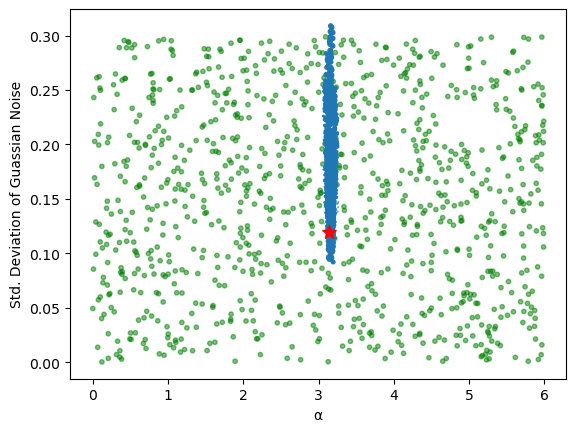

In [59]:
fig, ax = plt.subplots(1,1)
ax.scatter(prior_particles[0,:],prior_particles[1,:],s=prior_weights*1e4,color='green',alpha=0.5)
ax.scatter(pdf.particles[0,:],pdf.particles[1,:],s=pdf.weights*1e4)
ax.plot(true_params[0],true_params[1],"r*",ms=10)
ax.set_xlabel("α")
ax.set_ylabel("Std. Deviation of Guassian Noise")
plt.show()

## Visualize the possible particles without noise

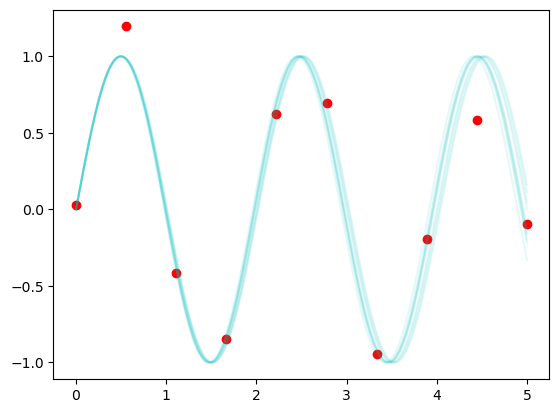

In [60]:
fig, ax = plt.subplots(1,1)
n_plots = 10
xs = jnp.linspace(0,5,1000)
ax.plot(inputs[0,:],outputs[0,:],'ro')

for i in range(n_plots):
    part = pdf.randdraw()
    α, sigma = part
    outs = y_means(xs,α)
    ax.plot(xs,outs[:,0],'-',c='c',alpha=0.1)
    
plt.show()